In [1]:
from scipy.linalg import expm
import numpy as np                                          # 导入numpy库并简写为np
import pandas as pd
import itertools
from joblib import Parallel, delayed
import seaborn as sns
import matplotlib.pyplot as plt
from QAOA import _Rx,_Rz,_Rzz,_Rzzz,_Rzzzz,I,_H,getBaseProb
def I(n): #返回可占用n个比特位的I矩阵
    return np.eye(2**n)

In [154]:
#---------------------- p=1 8th
def QaoaGetPara(gamma,beta,t,isOutStat = False):
    z = np.array([[1,0],
                    [0,-1]],dtype=np.complex128)
    A = _Rx(0,4,beta)*_Rx(1,4,beta)*_Rx(2,4,beta)*_Rx(3,4,beta) \
        *_Rz(0,4,gamma)*_Rz(1,4,gamma)*_Rz(3,4,-gamma) \
        *_Rzzz(0,1,2,4,-gamma)*_Rzzzz(gamma) \
        *(_H() + _H() + _H() + _H()) #代表量子线路的矩阵
    B = A.dot(t) # |gamma,beta>
    if isOutStat:
        return B
    H_C = 0.5* (5*I(4)+np.kron(z,I(3)) + np.kron(np.kron(I(1),z),I(2))   \
            - np.kron(I(3),z) -np.kron(np.kron(np.kron(z,z),z),I(1)) \
            + np.kron(np.kron(np.kron(z,z),z),z))
    E = np.conjugate(np.array(B)).T.dot(H_C).dot(np.array(B))[0][0].real # 计算期望
    return (E,gamma,beta)

t = np.concatenate((np.array([1]) , np.zeros((15)))).reshape(-1,1)
N = 100
beta_lst = np.linspace(0,2*np.pi,N)
gamma_lst = np.linspace(0,2*np.pi,N) 
#*********** 并行版本 ******************
table = Parallel(n_jobs=-1)(delayed(QaoaGetPara)(beta,gamma,t) for beta,gamma in itertools.product(beta_lst,gamma_lst)) #并行版本
table = pd.DataFrame(table,columns = ["E","gamma","beta"])
row_idx = table["E"].idxmax()
row = table.loc[row_idx,["gamma", "beta"]] # E_max对应列
pureState = QaoaGetPara(row["gamma"],row["beta"],t,True) # 返回该最优量子线路输出的纯态
State = getBaseProb(pureState) # 返回每个基态的概率
print(State)

[0.03644813+4.74243587e-20j 0.14837749+6.30083386e-18j
 0.06241526-1.88814546e-19j 0.25408763-7.93667797e-19j
 0.02859354-7.20624155e-19j 0.11640203+6.19358847e-19j
 0.00262641+8.82115291e-20j 0.01069189-3.60107000e-20j
 0.02859354+5.60747544e-19j 0.11640203-3.55016826e-19j
 0.00262641-4.67867369e-22j 0.01069189+9.40259316e-20j
 0.00496621-1.64046164e-19j 0.02021703-3.60043816e-20j
 0.03093333-3.35252897e-19j 0.12592718-4.25178422e-19j]


In [207]:
# ------------------p = 2 template 8th-----------------------------
def Qaoa2Stat(gamma_1,beta_1,gamma_2,beta_2,t):
    z = np.array([[1,0],
                    [0,-1]],dtype=np.complex128)
    A = _Rx(0,4,beta_2)*_Rx(1,4,beta_2)*_Rx(2,4,beta_2)*_Rx(3,4,beta_2) \
        *_Rz(0,4,gamma_2)*_Rz(1,4,gamma_2)*_Rz(3,4,-gamma_2) \
        *_Rzzz(0,1,2,4,-gamma_2)*_Rzzzz(gamma_2) \
        *_Rx(0,4,beta_1)*_Rx(1,4,beta_1)*_Rx(2,4,beta_1)*_Rx(3,4,beta_1) \
        *_Rz(0,4,gamma_1)*_Rz(1,4,gamma_1)*_Rz(3,4,-gamma_1) \
        *_Rzzz(0,1,2,4,-gamma_1)*_Rzzzz(gamma_1) \
        *(_H() + _H() + _H() + _H()) #代表量子线路的矩阵
    B = A.dot(t) # |gamma,beta>
    return B
def Qaoa2E(gamma_1,beta_1,gamma_2,beta_2,t,H_C):

    pureState = Qaoa2Stat(gamma_1,beta_1,gamma_2,beta_2,t)
    E = np.conjugate(np.array(pureState)).T.dot(H_C).dot(np.array(pureState ))[0][0].real
    if E > 4.2:
        print(gamma_1,beta_1,gamma_2,beta_2,E)
    return E
z = np.array([[1,0],
                [0,-1]],dtype=np.complex128)
H_C = 0.5* (5*I(4)+np.kron(z,I(3)) + np.kron(np.kron(I(1),z),I(2))   \
        - np.kron(I(3),z) -np.kron(np.kron(np.kron(z,z),z),I(1)) \
        + np.kron(np.kron(np.kron(z,z),z),z))

N = 40 #采样数
t = np.concatenate((np.array([1]) , np.zeros((15)))).reshape(-1,1) #创建初态
beta_1Lst = np.linspace(0,np.pi,int(N/2)) #生成遍历参数列表
gamma_1Lst = np.linspace(0,2*np.pi,N) 
beta_2Lst = np.linspace(0,np.pi,int(N/2))
gamma_2Lst = np.linspace(0,2*np.pi,N) 

#*********** 并行版本 ******************
E_lst = Parallel(n_jobs=-1)(delayed(Qaoa2E)(gamma_1,beta_1,gamma_2,beta_2,t,H_C) 
                for gamma_1,beta_1,gamma_2,beta_2 in itertools.product(gamma_1Lst,beta_1Lst,gamma_2Lst,beta_2Lst)) 
df = pd.DataFrame(list(itertools.product(gamma_1Lst,beta_1Lst,gamma_2Lst,beta_2Lst)), columns=["gamma_1","beta_1","gamma_2","beta_2"]) #得到参数的数据框
df.insert(0,column="E",value = E_lst) #将E_lst插入数据框

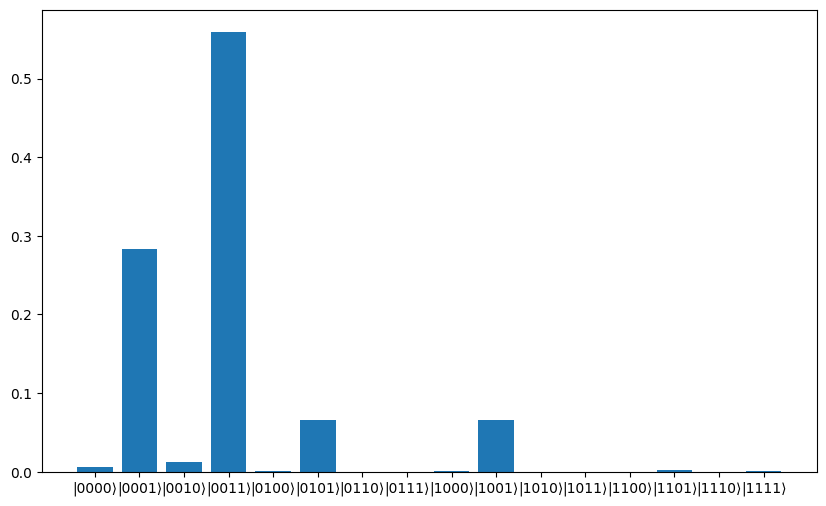

In [209]:
row = df.loc[df["E"].idxmax(),:] # E_max对应列
pureState = Qaoa2Stat(row["gamma_1"],row["beta_1"],row["gamma_2"],row["beta_2"],t) # 返回该最优量子线路输出的纯态
#print("pureState: \n", pureState)
State = getBaseProb(pureState) # 返回每个基态的概率
#print("State_prob: \n", State)
Xlabel = ["|{}{}{}{}⟩".format(x,y,z,r) for x,y,z,r in itertools.product([0,1],[0,1],[0,1],[0,1])]
plt.figure(figsize=(10,6))
plt.bar(Xlabel,State.real)
plt.show()

In [ ]:
def isError_df(df):
  E_adaLst = []
  for i,row in df.iterrows():
      E = Qaoa2E(row["gamma_1"],row["beta_1"],row["gamma_2"],row["beta_2"],t,H_C)
      #if row["E"] != E:
    #      print("idx = ",i, "is Error")
      E_adaLst.append(E)
  df.insert(1,"E_ada",E_adaLst)
  return df[df["E"] != df["E_ada"]]